<a href="https://colab.research.google.com/github/mani2106/Competition-Notebooks/blob/master/Lunar%20Rock/Lunar_Rock_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download data from link

In [1]:
!wget -O data.zip http://hck.re/kkBIfM

--2019-12-18 15:44:46--  http://hck.re/kkBIfM
Resolving hck.re (hck.re)... 18.140.32.73, 13.251.144.131, 52.77.195.45
Connecting to hck.re (hck.re)|18.140.32.73|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from hck.re attempted to set domain to hackerearth.com
Cookie coming from hck.re attempted to set domain to hackerearth.com
Cookie coming from hck.re attempted to set domain to hackerearth.com
Location: https://he-public-data.s3-ap-southeast-1.amazonaws.com/DataSet.zip [following]
--2019-12-18 15:44:47--  https://he-public-data.s3-ap-southeast-1.amazonaws.com/DataSet.zip
Resolving he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)... 52.219.40.75
Connecting to he-public-data.s3-ap-southeast-1.amazonaws.com (he-public-data.s3-ap-southeast-1.amazonaws.com)|52.219.40.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 733209860 (699M) [application/zip]
Saving to: ‘data.

### Unzip data

In [2]:
!unzip data.zip

Archive:  data.zip
   creating: DataSet/
 extracting: DataSet/Test Images.zip  
  inflating: DataSet/test.csv        
  inflating: DataSet/train.csv       
 extracting: DataSet/Train Images.zip  


In [0]:
!rm data.zip

In [0]:
!unzip "DataSet/Train Images.zip" -d DataSet

In [0]:
!unzip "DataSet/Test Images.zip" -d DataSet

### Import Libraries

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, auc_roc_score
from fastai.callbacks.tracker import ReduceLROnPlateauCallback, SaveModelCallback
from fastai.callbacks import CSVLogger

### Seeding the process

In [0]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [0]:
reset_seed()

### Setup paths

In [0]:
# ! mkdir drive/My\ Drive/Competition\ Models
# ! mkdir drive/My\ Drive/Competition\ Models/Lunar\ Rock

In [0]:
# WEIGHTS_PATH = Path('drive/My Drive/Competition Models/Lunar Rocks')
DATA_PATH = Path('DataSet')

### Read labels from dataframes

In [11]:
train_labels = pd.read_csv(DATA_PATH/'train.csv')
train_labels.head()

,Image_File,Class
0,clean2416.png,Large
1,ground4022.png,Small
2,ground0340.png,Small
3,ground2110.png,Small
4,clean1581.png,Large


### Create function to return DataBunch objects

In [0]:
def return_train_data(size, bs):
    return ImageDataBunch.from_folder(
            path=DATA_PATH/'Train Images',
            train='Train Images',
            valid_pct=0.2,
            ds_tfms=get_transforms(),
            size=size,
            bs=bs,
            resize_method=ResizeMethod.SQUISH,
            padding_mode='zeros'
        ).normalize(imagenet_stats)

### Prepare data from training

In [0]:
data = return_train_data(size=64, bs=250)

In [0]:
# Check classes
# import os
assert len(data.classes) == len(set(train_labels['Class'].values))

### Create Learner Object

In [15]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate])\
        .mixup()\
        .to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.5MB/s]


In [0]:
callbacks_list = [
    # ReduceLROnPlateauCallback(learn=learn, monitor='error_rate', factor=1e-6,
    #                           patience=20, min_delta=1e-5),
    SaveModelCallback(learn, mode="min", every='improvement', monitor='error_rate', name='best'),
    CSVLogger(learn=learn, append=True)
]

### Find optimal learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 1.00E-02


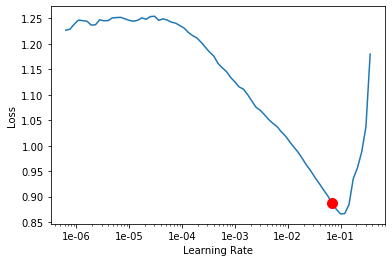

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

### Train model

In [18]:
learn.fit_one_cycle(5, min_grad_lr, callbacks=callbacks_list, wd=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.556827,0.119793,0.039600,01:32
1,0.421942,0.067985,0.030846,01:32
2,0.338795,0.027108,0.009170,01:32
3,0.293775,0.026987,0.005419,01:31
4,0.272933,0.017644,0.002918,01:31


Better model found at epoch 0 with error_rate value: 0.03959979489445686.
Better model found at epoch 1 with error_rate value: 0.030846135690808296.
Better model found at epoch 2 with error_rate value: 0.009170450270175934.
Better model found at epoch 3 with error_rate value: 0.005418898072093725.
Better model found at epoch 4 with error_rate value: 0.002917857374995947.


### Interpret results

In [0]:
learn.load('best');

In [0]:
interp = learn.interpret()

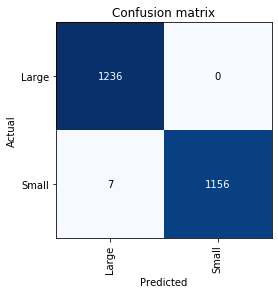

In [20]:
interp.plot_confusion_matrix()

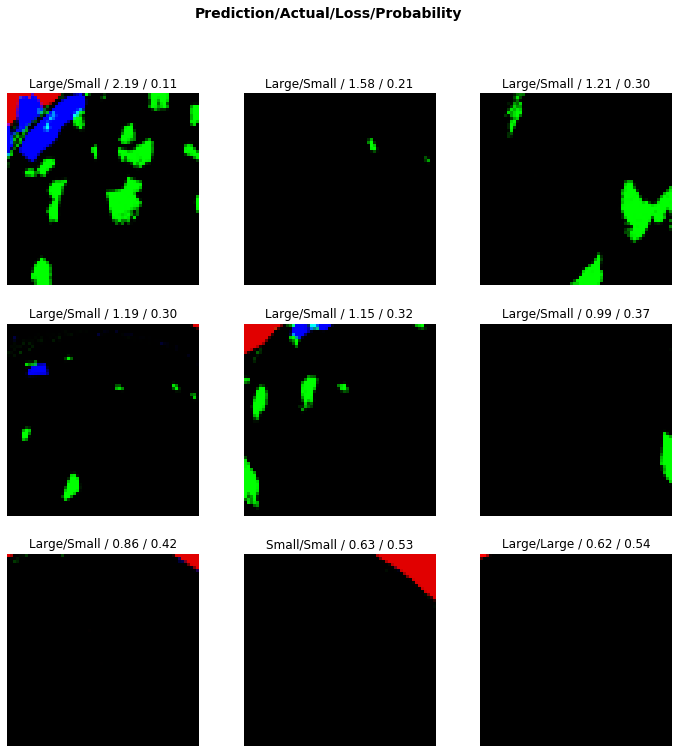

In [21]:
interp.plot_top_losses(9)

### Fine tune model

In [28]:
learn.to_fp16()
learn.unfreeze()
learn.lr_find(start_lr=1e-10)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-09
Min loss divided by 10: 2.69E-10


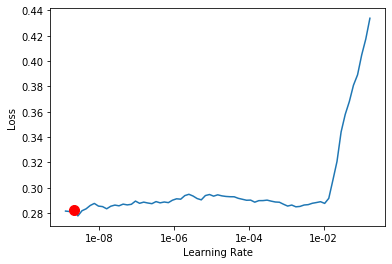

In [29]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [30]:
learn.fit_one_cycle(2, slice(min_grad_lr//20, min_grad_lr), callbacks=callbacks_list)

epoch,train_loss,valid_loss,error_rate,time
0,0.298768,0.044111,0.005002,02:14
1,0.297110,0.044100,0.005002,02:13


Better model found at epoch 0 with error_rate value: 0.0050020841881632805.


### Train with bigger data

In [0]:
learn.data = return_train_data(size=128, bs=128)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-03


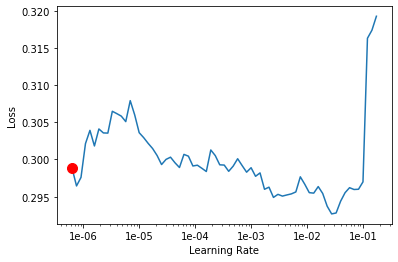

In [32]:
learn.load('best');
learn.to_fp16()
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.unfreeze()
learn.freeze_to(-3)

In [34]:
learn.fit_one_cycle(3, slice(min_grad_lr//4, min_grad_lr), callbacks=callbacks_list, wd=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.299281,0.046263,0.002501,02:13
1,0.299196,0.044595,0.002918,02:12
2,0.296515,0.044101,0.002918,02:11


Better model found at epoch 0 with error_rate value: 0.0025010420940816402.


In [0]:
learn.load("best");
learn.to_fp32()
learn.export("lunar_128.pkl")
# learn.save("lunar_224")

### Train with bigger data

In [0]:
learn.data = return_train_data(size=224, bs=64)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 4.79E-03


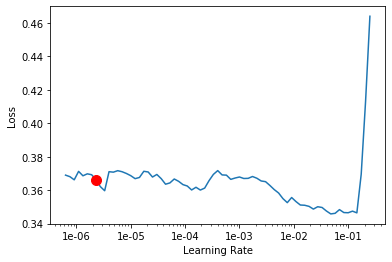

In [37]:
learn.load('best');
learn.to_fp16()
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [38]:
learn.fit_one_cycle(3, slice(min_grad_lr//30, min_grad_lr), callbacks=callbacks_list, wd=1e-10)

epoch,train_loss,valid_loss,error_rate,time
0,0.353176,0.061242,0.013756,04:06
1,0.359197,0.054349,0.012922,04:06
2,0.359264,0.058256,0.012505,04:06


Better model found at epoch 0 with error_rate value: 0.013755731284618378.
Better model found at epoch 1 with error_rate value: 0.012922050431370735.
Better model found at epoch 2 with error_rate value: 0.012505210936069489.


In [0]:
learn.load("best");
learn.to_fp32()
learn.export("lunar_224.pkl")
# learn.save("lunar_224")

### Train with bigger data

In [0]:
learn.data = return_train_data(size=332, bs=32)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 4.79E-03


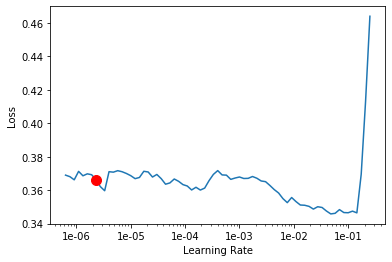

In [0]:
learn.load('best');
learn.to_fp16()
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
learn.fit_one_cycle(10, slice(min_grad_lr//2, min_grad_lr), callbacks=callbacks_list, wd=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.353176,0.061242,0.013756,04:06
1,0.359197,0.054349,0.012922,04:06


Better model found at epoch 0 with error_rate value: 0.013755731284618378.
Better model found at epoch 1 with error_rate value: 0.012922050431370735.


In [0]:
learn.load("best");
learn.to_fp32()
learn.export("lunar_332.pkl")

### Predict with test data

In [0]:
sample_df = pd.read_csv(DATA_PATH/"test.csv")

In [41]:
sample_df.head()

,Image_File,Class
0,lg 988 (1).png,NaN
1,lg 988 (10).png,NaN
2,lg 988 (100).png,NaN
3,lg 988 (101).png,NaN
4,lg 988 (102).png,NaN


In [0]:
learn.data.add_test(ImageList.from_df(sample_df, DATA_PATH,folder='Test Images'))

In [0]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

In [0]:
labelled_preds = []

for pred in preds:
    labelled_preds.append(learn.data.classes[np.argmax(pred)])

sample_df['Class'] = labelled_preds

In [0]:
sample_df.to_csv('submission.csv', index=False)